## Importing the packages
Here are the packages that we will work with

In [1]:
import scipy.io
import numpy as np
import scipy.misc
from matplotlib import pyplot as plt
from PIL import Image
from scipy import fftpack, signal
from scipy.linalg import circulant
import cv2

import sklearn
from sklearn.decomposition import PCA
import sklearn.neighbors


import warnings
warnings.filterwarnings('ignore')



## Consants and default values:

In [2]:
alpha = 3
window_size = 15
filter_range_sinc = window_size/4  
filter_range_gaussian = window_size / 16
expectancy = 0
sigma = 1
T = 3
image_path="DIPSourceHW2.png"


patch_size = 4
sigma_NN = 0.06
num_neighbors = 2
pca_num_components = 25
epsilon = 1e-10
wiener_filter_constant=0.02

## Downsampling and Shrinking

In [3]:

## The case in one dimension
def Downsample_Shrink_One_Dimension(matrix, alpha):
    (matrix_shape_x, matrix_shape_y) = matrix.shape
    resize =(int(matrix_shape_x / alpha), int(matrix_shape_y))
    downsampled_matrix = np.zeros(resize)
    for i in range(resize[0]):
        downsampled_matrix[i,:] = matrix[alpha * i, :]
    return downsampled_matrix



## Downsample matrix
def Downsample_Shrink(matrix, alpha):
    (matrix_shape_x, matrix_shape_y) = matrix.shape
    resize =(int(matrix_shape_x / alpha), int(matrix_shape_y / alpha))
    downsampled_matrix = np.zeros(resize)
    for i in range(resize[0]):
        for j in range(resize[1]):
            downsampled_matrix[i, j] = matrix[alpha * i, alpha * j]
    return downsampled_matrix



## Upsampling
Here we use the cubic interpolation

In [4]:
def Upsample(matrix,alpha):
    (matrix_shape_x, matrix_shape_y) = matrix.shape
    resize = (int(matrix_shape_y * alpha), int(matrix_shape_x * alpha))
    upsampled_with_filter = cv2.resize(matrix, dsize=resize, interpolation=cv2.INTER_CUBIC)
    return upsampled_with_filter

## Sinc Matrix 

In [5]:
def sinc(window_size, filter_range):
    x = np.linspace(-filter_range, filter_range, window_size)
    x_x = np.outer(x, x)
    matrix = np.sinc(x_x)
    matrix = matrix / matrix.sum()
    return matrix

## Laplacian Matrix

In [6]:
def laplacian(matrix_length):
    matrix = np.zeros((matrix_length ** 2, matrix_length ** 2))

    main_diagonal_pattern = np.zeros((matrix_length, matrix_length))
    for i in range(matrix_length):
        for j in range(matrix_length):
            if abs(i-j) == 1:
                main_diagonal_pattern[i, j] = -1

            if i == j:
                main_diagonal_pattern[i, j] = 4
            

    secondary_diagonal_pattern = np.zeros((matrix_length, matrix_length))
    for i in range(matrix_length):
        secondary_diagonal_pattern[i, i] = -1


    end_index = matrix_length
    start_index = 0

    for i in range(matrix_length):
        matrix[start_index:end_index, start_index:end_index] = main_diagonal_pattern
        start_index += matrix_length
        end_index += matrix_length

    start_index_x = 0
    end_index_x = matrix_length
    start_index_y = matrix_length
    end_index_y = 2 * matrix_length

    for i in range(matrix_length - 1):
        matrix[start_index_x:end_index_x, start_index_y:end_index_y] = secondary_diagonal_pattern
        matrix[start_index_y:end_index_y, start_index_x:end_index_x] = secondary_diagonal_pattern

        start_index_x += matrix_length
        end_index_x += matrix_length
        start_index_y += matrix_length
        end_index_y += matrix_length

    return matrix

## Gaussian Matrix

In [7]:
def gaussian(window_size, filter_range, expectancy, sigma):
    z = np.linspace(-filter_range, filter_range, window_size)
    x, y = np.meshgrid(z, z)
    distance = np.sqrt(x*x+y*y)
    matrix = np.exp(-((distance-expectancy)**2 / (2.0 * sigma**2)))
    matrix = matrix / matrix.sum()
    return matrix

## Dividing into patches 
Here we divide the image into patches according to a given step size and then we store the results in an array

In [8]:
def Divide_Into_Patches(image, patch_size, step):
    patches_array = []
    for i in range(0,int(image.shape[0] - patch_size),step):
        for j in range(0,int(image.shape[1] - patch_size),step):
            current_patch = image[i:i+patch_size,j:j+patch_size]
            patches_array.append(current_patch)
    return patches_array

## Restore with Wiener filter
Here we try to restore the image using a Wiener Filter which gets the image and the PSF_kernel and the filter_constant as parameters

In [9]:
def Wiener_Filter(image, psf_kernel, filter_costant):
    if np.sum(psf_kernel):
        psf_kernel /= np.sum(psf_kernel)
    restord = fftpack.fft2(np.copy(image))
    psf_kernel = fftpack.fft2(psf_kernel, shape=image.shape)
    psf_kernel = np.conj(psf_kernel) / (np.abs(psf_kernel) ** 2 + filter_costant)
    restord = np.abs(fftpack.ifft2(restord * psf_kernel))
    return restord


## Claculating PSNR and saving the Images and Plotting the Results

In [10]:
def Save_Image(image,  name, save_format):
    image = image / image.max()
    image_256 = image * 255
    to_save = Image.fromarray(image_256)
    to_save = to_save.convert('RGB')
    to_save.save(name + save_format)


def Calculate_PSNR(original_image, restored_image):
    MSE = np.mean((original_image - restored_image) *(original_image - restored_image))
    max_value = original_image.max()
    PSNR = 20 * np.log10(max_value / (np.sqrt(MSE)))
    return PSNR

def Plot_Results(restored_image, blurring_method, restoration_method, original_image,kind):
    plt.imshow(restored_image, cmap='gray')
    PSNR = Calculate_PSNR(original_image[5:-5, 5:-5], restored_image[5:-5, 5:-5])
    plt.title(f'Blurred using {blurring_method}\n and Restored using the estimated {restoration_method}  PSNR={PSNR:.2f}')
    if kind==1:
        plt.savefig("Images/High Resolution Estimation/Correct/Blurred with sinc Kernel and restored with estimated sinc Kernel")
    if kind==2:
        plt.savefig("Images/High Resolution Estimation/Faulty/Blurred with sinc Kernel and restored with estimated Gaussian Kernel")
    if kind==3:
        plt.savefig("Images/High Resolution Estimation/Correct/Blurred with Gaussian Kernel and restored with estimated Gaussian Kernel")
    if kind==4:
        plt.savefig("Images/High Resolution Estimation/Faulty/Blurred with Gaussian Kernel and restored with estimated sinc Kernel")
    plt.show()
        

## Helper functions for the kernel estimation part

In [11]:
def Create_q_Patches_Vector(q_patches):
    q_patches_vec = []
    for decimated_patch in q_patches:
        curr_q_vec = decimated_patch.reshape(decimated_patch.size)
        q_patches_vec.append(curr_q_vec)
    q_patches_vec = np.array(q_patches_vec)
    return q_patches_vec

def Create_Rj_Vector(r_patches,alpha):
    Rj = []
    for r_patch in r_patches:
        r_circulant = circulant(r_patch.reshape(r_patch.size))
        Rj.append(Downsample_Shrink_One_Dimension(r_circulant, alpha ** 2))
    return Rj

def Initialize_Kernel(patch_size):
    delta = fftpack.fftshift(scipy.signal.unit_impulse((patch_size, patch_size)))
    init_k = delta.reshape(delta.size)
    return init_k

def Create_rj_alpha_Patches(r_patches,curr_k,Rj):
    r_alpha_patches = []
    for j, patch in enumerate(r_patches):
        curr_patch_alpha = Rj[j] @ curr_k
        r_alpha_patches.append(curr_patch_alpha)
    r_alpha_patches = np.array(r_alpha_patches)
    return r_alpha_patches

def Find_Nearest_Neighbors_Calc_Weights(r_alpha_patches,q_patches_vec,num_neighbors,sigma_NN):
    tree = sklearn.neighbors.BallTree(r_alpha_patches, leaf_size=2)
    neighbors_weights = np.zeros((len(q_patches_vec), len(r_alpha_patches)))
    for i, decimated_patch_vec in enumerate(q_patches_vec):
        representative_patch = np.expand_dims(decimated_patch_vec, 0)
        _, neighbor_indices = tree.query(representative_patch, k=num_neighbors)
        for index in neighbor_indices:
            neighbors_weights[i, index] = np.exp(-0.5 * (np.linalg.norm(decimated_patch_vec - r_alpha_patches[index]) ** 2)/(sigma_NN ** 2))
    return neighbors_weights

def Calculate_Weights_Sums(sum_left,sum_right,Rj,neighbors_weights,patch_size,q_patches_vec):
        C = laplacian(patch_size)
        C_squared = C.T @ C
        for i in range(neighbors_weights.shape[0]):
            for j in range(neighbors_weights.shape[1]):
                if not neighbors_weights[i, j]:
                    continue
                R_squared = Rj[j].T @ Rj[j]

                sum_left += neighbors_weights[i, j] * (R_squared) + (C_squared)
                sum_right += neighbors_weights[i, j] * Rj[j].T @ q_patches_vec[i]
        return sum_left,sum_right

## Estimate Kernel
Calculating the restored kernel from the blurred image.


I this way we can generate an image with a higher resultion

In [12]:
def Estimate_Kernel(image, alpha, T,patch_size,sigma_NN,num_neighbors,pca_num_components,epsilon):
    decimated_patch_size = int(patch_size / alpha)
    patch_step_size_factor = 1 / decimated_patch_size  # We use this for patch partition

    ## Here it is the creation of the high-res and low res patches 
    r_patches = Divide_Into_Patches(image, patch_size, int(patch_size * patch_step_size_factor))
    q_patches = Divide_Into_Patches(image, decimated_patch_size, int(decimated_patch_size * patch_step_size_factor))

    q_patches_vec = Create_q_Patches_Vector(q_patches)
    

    # Calculating the Rj according to the algorithm (Downsampling)
    Rj = Create_Rj_Vector(r_patches,alpha)

    ## initial k to start iterative algorithm with
    curr_k=Initialize_Kernel(patch_size)

    for t in range(T):
        print(f'Entering Iteration : {t}')
        
        
        r_alpha_patches=Create_rj_alpha_Patches(r_patches,curr_k,Rj)
        
        neighbors_weights=Find_Nearest_Neighbors_Calc_Weights(r_alpha_patches,q_patches_vec,num_neighbors,sigma_NN)
        
        neighbors_weights_sum = np.sum(neighbors_weights, axis=1)
        epsilon_mat = np.eye(curr_k.shape[0]) * epsilon

        for row in range(neighbors_weights.shape[0]):
            row_sum = neighbors_weights_sum[row]
            if row_sum:
                neighbors_weights[row] = neighbors_weights[row] / row_sum  ## normalize each column

        ## calculate k hat
        sum_left = np.zeros((curr_k.shape[0], curr_k.shape[0]))
        sum_right = np.zeros_like(curr_k)

        sum_left,sum_right=Calculate_Weights_Sums(sum_left,sum_right,Rj,neighbors_weights,patch_size,q_patches_vec)

        curr_k = np.linalg.inv((1 / (sigma_NN ** 2)) * sum_left + epsilon_mat) @ sum_right
        curr_k_reshaped = curr_k.reshape((patch_size, patch_size))
    return curr_k_reshaped  ## as matrix in shape patch_size ** 2

## Preparing the Image and the Filters

In [13]:
image = plt.imread(image_path)
image = np.array(image)
image = image[:, :, 0]
image = image / image.max()
image_new_size = np.zeros((image.shape[0]+2, image.shape[1]+2))
image_new_size[1:-1, 1:-1] = image
image = image_new_size

sinc_filter = sinc(window_size, filter_range_sinc)
gaussian_filter = gaussian(window_size, filter_range_gaussian, expectancy, sigma)

## Running Everything

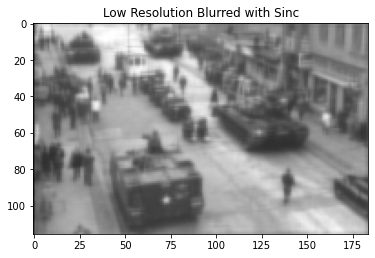

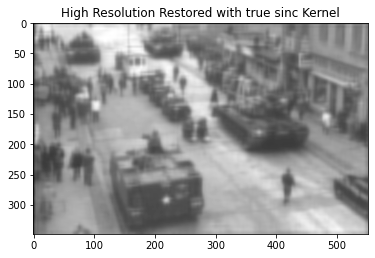

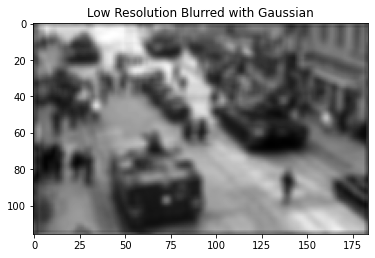

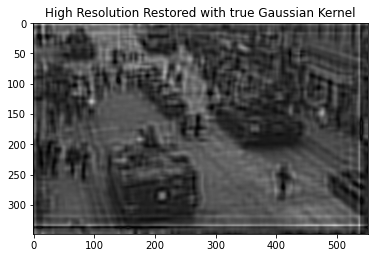

Estimating the Gaussian kernel
Entering Iteration : 0
Entering Iteration : 1
Entering Iteration : 2
*****************************
Estimating the sinc kernel
Entering Iteration : 0
Entering Iteration : 1
Entering Iteration : 2


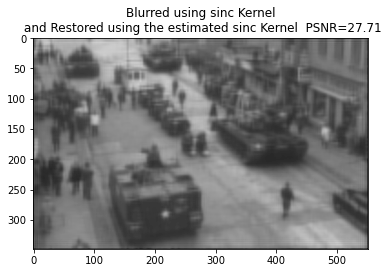

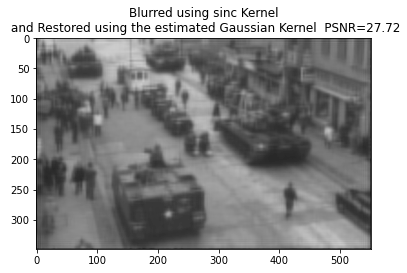

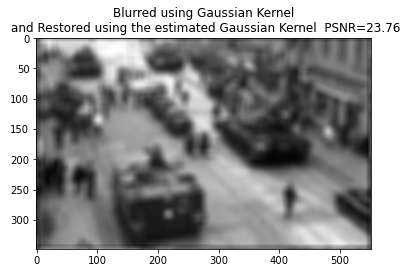

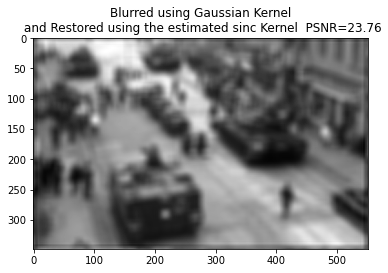

In [14]:
sinc_image_big = signal.convolve2d(image, sinc_filter, mode='same', boundary='wrap')
sinc_image = Downsample_Shrink(sinc_image_big, alpha)
low_res_sinc=sinc_image
sinc_image_high_res = Upsample(sinc_image, alpha)
##high_res_sinc_true=sinc_image_high_res
high_res_sinc_true=Wiener_Filter(sinc_image_high_res, sinc_filter, wiener_filter_constant)

gaussian_image_big = signal.convolve2d(image, gaussian_filter, mode='same', boundary='wrap')
gaussian_image = Downsample_Shrink(gaussian_image_big, alpha)
low_res_gaussian=gaussian_image
gaussian_image_high_res = Upsample(gaussian_image, alpha)
#high_res_gaussian_true=gaussian_image_high_res
high_res_gaussian_true=Wiener_Filter(sinc_image_high_res, gaussian_filter, wiener_filter_constant)

plt.imshow(low_res_sinc, cmap='gray')
plt.title("Low Resolution Blurred with Sinc")
plt.savefig("Images/Low Resolution/Low Resolution Blurred with Sinc")
plt.show()


plt.imshow(sinc_image_high_res, cmap='gray')
plt.title("High Resolution Restored with true sinc Kernel")
plt.savefig("Images/High Resolution True/High Resolution Restored with true sinc Kernel")
plt.show()



plt.imshow(low_res_gaussian, cmap='gray')
plt.title("Low Resolution Blurred with Gaussian")
plt.savefig("Images/Low Resolution/Low Resolution Blurred with Gaussian")
plt.show()

plt.imshow(high_res_gaussian_true, cmap='gray')
plt.title("High Resolution Restored with true Gaussian Kernel")
plt.savefig("Images/High Resolution True/High Resolution Restored with true Gaussian Kernel")
plt.show()

## Estimate the kernels after running the iterative algorithm
print("Estimating the Gaussian kernel")
gaussian_restored_k = Estimate_Kernel(gaussian_image, alpha,T,patch_size,sigma_NN,num_neighbors,pca_num_components,epsilon)
print("*****************************")
print("Estimating the sinc kernel")
sinc_restored_k = Estimate_Kernel(sinc_image, alpha, T,patch_size,sigma_NN,num_neighbors,pca_num_components,epsilon)

## restore each blurred image with both kernels
sinc_restored_image = Wiener_Filter(sinc_image_high_res, sinc_restored_k, wiener_filter_constant)
sinc_blurred_restored_from_gaussian_image = Wiener_Filter(sinc_image_high_res, gaussian_restored_k, wiener_filter_constant)
gaussian_restored_image= Wiener_Filter(gaussian_image_high_res, gaussian_restored_k, wiener_filter_constant)
gaussian_blurred_restored_from_sinc_image = Wiener_Filter(gaussian_image_high_res, sinc_restored_k, wiener_filter_constant)

## Plot the results after the estimation
Plot_Results(sinc_restored_image, "sinc Kernel", "sinc Kernel", image,1)
Plot_Results(sinc_blurred_restored_from_gaussian_image, "sinc Kernel", "Gaussian Kernel", image,2)
Plot_Results(gaussian_restored_image, "Gaussian Kernel", "Gaussian Kernel", image,3)
Plot_Results(gaussian_blurred_restored_from_sinc_image, "Gaussian Kernel", "sinc Kernel", image,4)
